#### Copyright 2018 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#  Case Study: Debugging in Regression

In this Colab, you will learn how to debug a regression problem through a case study. You will:

1. Set up the problem.
2. Interpret the correlation matrix.
3. Implement linear and nonlinear models.
4. Compare and choose between linear and nonlinear models.
5. Optimize your chosen model.
6. Debug your chosen model.


# Setup

This Colab uses the wine quality dataset<sup>[1]</sup>, which is hosted at [UCI](https://archive.ics.uci.edu/ml/datasets/wine+quality). This dataset contains data on the physicochemical properties of wine along with wine quality ratings. The problem is to predict wine quality (0-10) from physicochemical properties.

Please **make a copy** of this Colab before running it. Click on *File*, and then click on *Save a copy in Drive*.

<small>[1] Modeling wine preferences by data mining from physicochemical properties. P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Decision Support Systems, Elsevier, 47(4):547-553, 2009.</small>

Load libraries and data by running the next cell. Display the first few rows to verify that the dataset loaded correctly.

In [2]:
# Reset environment for a new run
% reset -f

# Load libraries
from os.path import join # for joining file pathnames
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Set Pandas display options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

wineDf = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/winequality.csv",
  encoding='latin-1')
wineDf.columns = ['fixed acidity','volatile acidity','citric acid',
                     'residual sugar','chlorides','free sulfur dioxide',
                     'total sulfur dioxide','density','pH',
                     'sulphates','alcohol','quality']
wineDf.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.3,0.4,20.7,0.0,45.0,170.0,1.0,3.0,0.5,8.8,6
1,6.3,0.3,0.3,1.6,0.0,14.0,132.0,1.0,3.3,0.5,9.5,6
2,8.1,0.3,0.4,6.9,0.1,30.0,97.0,1.0,3.3,0.4,10.1,6
3,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6
4,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6


# Check Correlation Matrix

Before developing your ML model, you need to select features. To find informative features, check the correlation matrix by running the following cell. Which features are informative?

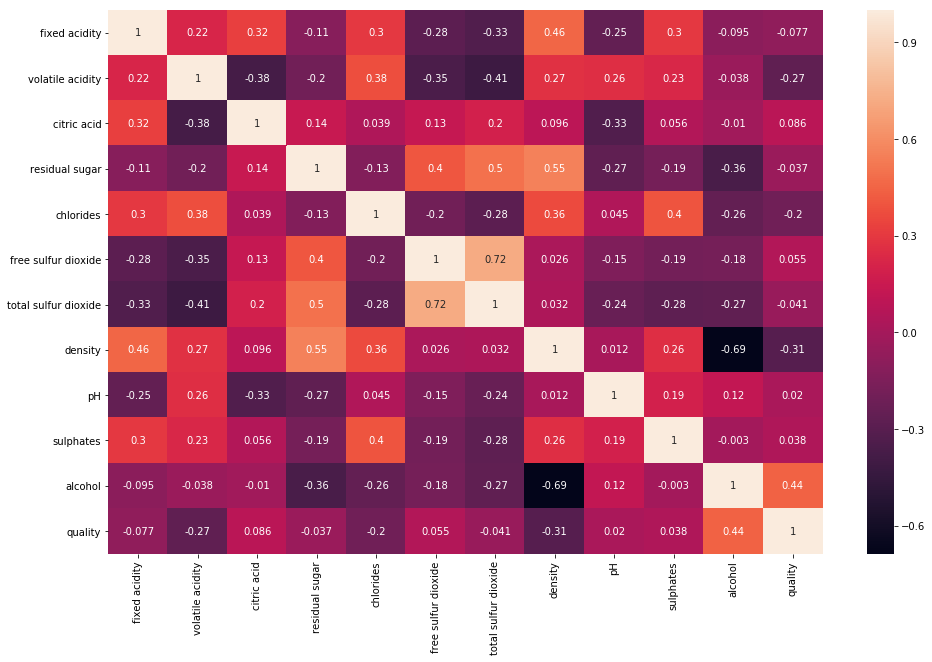

In [3]:
corr_wineDf = wineDf.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_wineDf, annot=True)

`alcohol` is most highly correlated with `quality`. Looking for other informative features, notice that `volatile acidity` correlates with `quality` but not with `alcohol`, making it a good second feature. Remember that a correlation matrix is not helpful if predictive signals are encoded in combinations of features.

# Validate Input Data against Data Schema

Before processing your data, you should validate the data against a data schema as described in [Data and Feature Debugging](https://developers.google.com/machine-learning/testing-debugging/common/data-errors).

First, define a function that validates data against a schema.

In [4]:
#@title Define function to validate data

def test_data_schema(input_data, schema):
  """Tests that the datatypes and ranges of values in the dataset
    adhere to expectations.

    Args:
      input_function: Dataframe containing data to test
      schema: Schema which describes the properties of the data.
  """

  def test_dtypes():
    for column in schema.keys():
      assert input_data[column].map(type).eq(
          schema[column]['dtype']).all(), (
          "Incorrect dtype in column '%s'." % column
      )
    print('Input dtypes are correct.')

  def test_ranges():
    for column in schema.keys():
      schema_max = schema[column]['range']['max']
      schema_min = schema[column]['range']['min']
      # Assert that data falls between schema min and max.
      assert input_data[column].max() <= schema_max, (
          "Maximum value of column '%s' is too low." % column
      )
      assert input_data[column].min() >= schema_min, (
          "Minimum value of column '%s' is too high." % column
      )
    print('Data falls within specified ranges.')

  test_dtypes()
  test_ranges()

To define your schema, you need to understand the statistical properties of your dataset. Generate statistics on your dataset by running the following code cell:

In [5]:
wineDf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0
mean,7.2,0.3,0.3,5.4,0.1,30.5,115.7,1.0,3.2,0.5,10.5,5.8
std,1.3,0.2,0.1,4.8,0.0,17.7,56.5,0.0,0.2,0.1,1.2,0.9
min,3.8,0.1,0.0,0.6,0.0,1.0,6.0,1.0,2.7,0.2,8.0,3.0
25%,6.4,0.2,0.2,1.8,0.0,17.0,77.0,1.0,3.1,0.4,9.5,5.0
50%,7.0,0.3,0.3,3.0,0.0,29.0,118.0,1.0,3.2,0.5,10.3,6.0
75%,7.7,0.4,0.4,8.1,0.1,41.0,156.0,1.0,3.3,0.6,11.3,6.0
max,15.9,1.6,1.7,65.8,0.6,289.0,440.0,1.0,4.0,2.0,14.9,9.0


Using the statistics generated above, define the data schema in the following code cell. For demonstration purposes, restrict your data schema to the first three data columns. For each data column, enter the:

 * minimum value
 * maximum value
 * data type

As an example, the values for the first column are filled out. After entering the values, run the code cell to confirm that your input data matches the schema.

In [9]:
wine_schema = {
    'fixed acidity': {
        'range': {
            'min': 3.8,
            'max': 15.9
        },
        'dtype': float,
    },
    'volatile acidity': {
        'range': {
            'min': 0.08, # describe() rounds up this value, be careful
            'max': 1.6,
        },
        'dtype': float,
    },
    'citric acid': {
        'range': {
            'min': 0.0,
            'max': 1.7,
        },
        'dtype': float,
    }
}

print('Validating wine data against data schema...')
test_data_schema(wineDf, wine_schema)

Validating wine data against data schema...
Input dtypes are correct.
Data falls within specified ranges.


## Solution

In [8]:
wine_schema = {
    'fixed acidity': {
        'range': {
            'min': 3.7,
            'max': 15.9
        },
        'dtype': float,
    },
    'volatile acidity': {
        'range': {
            'min': 0.08,  # minimum value
            'max': 1.6   # maximum value
        },
        'dtype': float,    # data type
    },
    'citric acid': {
        'range': {
            'min': 0.0, # minimum value
            'max': 1.7  # maximum value
        },
        'dtype': float,   # data type
    }
}

print('Validating wine data against data schema...')
test_data_schema(wineDf, wine_schema)

Validating wine data against data schema...
Input dtypes are correct.
Data falls within specified ranges.


# Split and Normalize Data

Split the dataset into data and labels.

In [10]:
wineFeatures = wineDf.copy(deep=True)
wineFeatures.drop(columns='quality',inplace=True)
wineLabels = wineDf['quality'].copy(deep=True)

Normalize data using z-score.

In [11]:
def normalizeData(arr):
  stdArr = np.std(arr)
  meanArr = np.mean(arr)
  arr = (arr-meanArr)/stdArr
  return arr

for str1 in wineFeatures.columns:
   wineFeatures[str1] = normalizeData(wineFeatures[str1])

# Test Engineered Data

After normalizing your data, you should test your engineered data for errors as described in [Data and Feature Debugging](https://developers.google.com/machine-learning/testing-debugging/common/data-errors). In this section, you will test that engineering data:

* Has the expected number of rows and columns.
* Does not have null values.

First, set up the testing functions by running the following code cell:


In [12]:
import unittest

def test_input_dim(df, n_rows, n_columns):
  assert len(df) == n_rows, "Unexpected number of rows."
  assert len(df.columns) == n_columns, "Unexpected number of columns."
  print('Engineered data has the expected number of rows and columns.')

def test_nulls(df):
  dataNulls = df.isnull().sum().sum()
  assert dataNulls == 0, "Nulls in engineered data."
  print('Engineered features do not contain nulls.')

Your input data had 6497 examples and 11 feature columns. Test whether your engineered data has the expected number of rows and columns by running the following cell. Confirm that the test fails if you change the values below.

In [13]:
#@title Test dimensions of engineered data
wine_feature_rows = 6497 #@param
wine_feature_cols = 11 #@param
test_input_dim(wineFeatures,
               wine_feature_rows,
               wine_feature_cols)

Engineered data has the expected number of rows and columns.


Test that your engineered data does not contain nulls by running the code below.

In [14]:
test_nulls(wineFeatures)

Engineered features do not contain nulls.


# Check Splits for Statistical Equivalence

As described in the [Data Debugging](https://developers.google.com/machine-learning/testing-debugging/common/data-errors) guidelines, before developing your model, you should check that your training and validation splits are equally representative. Assuming a training:validation split of 80:20, compare the mean and the standard deviation of the splits by running the next two code cells. Note that this comparison is not a rigorous test for statistical equivalence but simply a quick and dirty comparison of the splits.

In [15]:
splitIdx = wineFeatures.shape[0]*8/10
wineFeatures.iloc[0:splitIdx,:].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0,5197.0
mean,-0.2,-0.3,0.1,0.2,-0.2,0.2,0.3,-0.2,-0.1,-0.2,-0.0
std,0.7,0.8,0.9,1.1,0.9,1.0,0.8,1.0,1.0,0.9,1.0
min,-2.6,-1.6,-2.2,-1.0,-1.3,-1.6,-1.9,-2.5,-3.1,-2.1,-2.1
25%,-0.7,-0.8,-0.4,-0.8,-0.6,-0.5,-0.2,-1.0,-0.8,-0.8,-0.9
50%,-0.3,-0.4,-0.1,-0.1,-0.3,0.1,0.3,-0.2,-0.2,-0.3,-0.2
75%,0.1,0.0,0.5,0.9,-0.1,0.8,0.9,0.6,0.4,0.2,0.7
max,6.0,6.0,9.2,12.7,15.8,14.6,5.7,14.8,4.2,9.9,3.1


In [16]:
wineFeatures.iloc[splitIdx:-1,:].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0,1299.0
mean,0.9,1.1,-0.3,-0.6,0.8,-0.8,-1.3,0.7,0.6,0.8,0.0
std,1.4,1.1,1.3,0.3,1.1,0.6,0.6,0.7,1.0,1.0,0.9
min,-1.8,-1.3,-2.2,-1.0,-1.3,-1.7,-1.9,-1.5,-2.2,-1.1,-1.8
25%,-0.1,0.3,-1.5,-0.7,0.4,-1.3,-1.7,0.3,-0.1,0.1,-0.7
50%,0.6,1.0,-0.3,-0.7,0.7,-0.9,-1.4,0.7,0.5,0.6,-0.1
75%,1.7,1.8,0.8,-0.6,1.0,-0.5,-1.0,1.1,1.1,1.3,0.7
max,6.7,7.5,3.2,2.1,10.4,2.3,3.1,3.0,4.9,7.3,3.7


The two splits are clearly not equally representative. To make the splits equally representative, you can shuffle the data.

Run the following code cell to shuffle the data, and then recreate the features and labels from the shuffled data.

In [17]:
# Shuffle data
wineDf = wineDf.sample(frac=1).reset_index(drop=True)
# Recreate features and labels
wineFeatures = wineDf.copy(deep=True)
wineFeatures.drop(columns='quality',inplace=True)
wineLabels = wineDf['quality'].copy(deep=True)

Now, confirm that the splits are equally representative by regenerating and comparing the statistics using the previous code cells. You may wonder why the initial splits differed so greatly. It turns out that in the wine dataset, the first 4897 rows contain data on white wines and the next 1599 rows contain data on red wines. When you split your dataset 80:20, then your training dataset contains 5197 examples, which is 94% white wine. The validation dataset is purely red wine. 

Ensuring your splits are statistically equivalent is a good development practice. In general, following good development practices will simplify your model debugging. To learn about testing for statistical equivalence, see [Equivalence Tests Lakens, D.](https://journals.sagepub.com/doi/10.1177/1948550617697177).

# Establish a Baseline

For a regression problem, the simplest baseline to predict the average value. Run the following code to calculate the mean-squared error (MSE) loss on the training split using the average value as a baseline. Your loss is approximately 0.75. Any model should beat this loss to justify its use.

In [18]:
baselineMSE = np.square(wineLabels[0:splitIdx]-np.mean(wineLabels[0:splitIdx]))
baselineMSE = np.sum(baselineMSE)/len(baselineMSE)
print(baselineMSE)

0.7599125899998034


# Linear Model

Following good ML dev practice, let's start with a linear model that uses the most informative feature from the correlation matrix: `alcohol`. Even if this model performs badly, we can still use it as a baseline. This model should beat our previous baseline's MSE of 0.75.

First, let's define a function to plot our loss and accuracy curves. The function will also print the final loss and accuracy. Instead of using `verbose=1`, you can call the function.

In [19]:
def showRegressionResults(trainHistory):
  """Function to:
   * Print final loss.
   * Plot loss curves.
  
  Args:
    trainHistory: object returned by model.fit
  """
  
  # Print final loss
  print("Final training loss: " + str(trainHistory.history['loss'][-1]))
  print("Final Validation loss: " + str(trainHistory.history['val_loss'][-1]))
  
  # Plot loss curves
  plt.plot(trainHistory.history['loss'])
  plt.plot(trainHistory.history['val_loss'])
  plt.legend(['Training loss','Validation loss'],loc='best')
  plt.title('Loss Curves')

For fast prototyping, let's try using a full batch per epoch to update the gradient only once per  epoch. Use the full batch by setting `batch_size = wineFeatures.shape[0]` as indicated by the code comment.

What do you think of the loss curve? Can you improve it? For hints and discussion, see the following text cells.

Final training loss: 0.7095267631949336
Final Validation loss: 0.6481150732590601


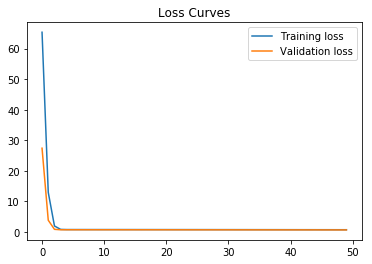

In [22]:
model = None
# Choose feature
wineFeaturesSimple = wineFeatures['alcohol']
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(units=1, activation='linear', input_dim=1))
# Specify the optimizer using the TF API to specify the learning rate
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss='mse')
# Train the model!
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=50,
                         batch_size= 100, # set batch size here
                         validation_split=0.2,
                         verbose=0)
# Plot
showRegressionResults(trainHistory)

## Hint

The loss decreases but very slowly. Possible fixes are:

* Increase number of epochs.
* Increase learning rate.
* Decrease batch size. A lower batch size can result in larger decrease in loss per epoch, under the assumption that the smaller batches stay representative of the overall data distribution.

Play with these three parameters in the code above to decrease the loss.

## Solution

Run the following code cell to train the model using a reduced batch size of 100. Reducing the batch size leads to a greater decrease in loss per epoch. The minimum achievable loss is about 0.64. This is a significant increase over our baseline of 0.75.

Final training loss: 0.6809901511506299
Final Validation loss: 0.6257625107581799


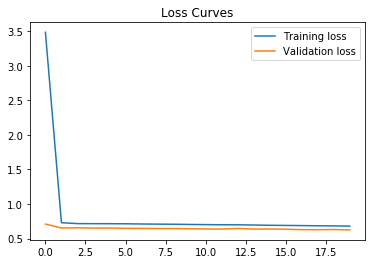

In [21]:
model = None
# Choose feature
wineFeaturesSimple = wineFeatures['alcohol']
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(units=1, activation='linear', input_dim=1))
# Specify the optimizer using the TF API to specify the learning rate
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss='mse')
# Train the model!
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=20,
                         batch_size=100, # set batch size here
                         validation_split=0.2,
                         verbose=0)
# Plot
showRegressionResults(trainHistory)

# Add Feature to Linear Model

Try adding a feature to the linear model. Since you need to combine the two features into one prediction for regression, you'll also need to add a second layer. Modify the code below to implement the following changes:

1. Add `'volatile acidity'` to the features in `wineFeaturesSimple`.
1. Add a second linear layer with 1 unit.
1. Experiment with learning rate, epochs, and batch_size to try to reduce loss.

What happens to your loss?

Final training loss: 0.6531214030724386
Final Validation loss: 0.5994833524410541


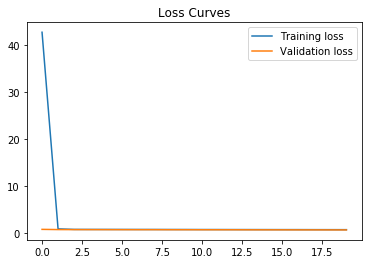

In [30]:
model = None
# Select features
wineFeaturesSimple = wineFeatures[['alcohol', 'volatile acidity']] # add second feature
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             input_dim=wineFeaturesSimple.shape[1],
                             activation='linear'))
model.add(keras.layers.Dense(1, activation='linear')) # add second layer
# Compile
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')
# Train
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=20,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)

## Solution

Run the following code to add the second feature and the second layer. The training loss is about 0.59, a small decrease from the previous loss of 0.64.

Final training loss: 0.6217429693763201
Final Validation loss: 0.5788564750781426


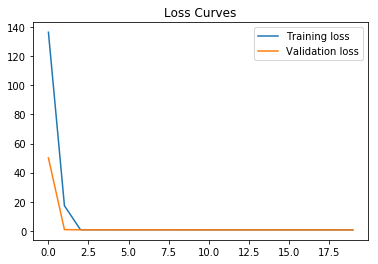

In [31]:
model = None
# Select features
wineFeaturesSimple = wineFeatures[['alcohol', 'volatile acidity']] # add second feature
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             input_dim=wineFeaturesSimple.shape[1],
                             activation='linear'))
model.add(keras.layers.Dense(1, activation='linear')) # add second layer
# Compile
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')
# Train
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=20,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)

# Use a Nonlinear Model

Let's try a nonlinear model. Modify the code below to make the following changes:

1. Change the first layer to use `relu`. (Output layer stays linear since this is a regression problem.)
1. As usual, specify the learning rate, epochs, and batch_size.

Run the cell. Does the loss increase, decrease, or stay the same?

Final training loss: 0.6217429693763201
Final Validation loss: 0.5788564750781426


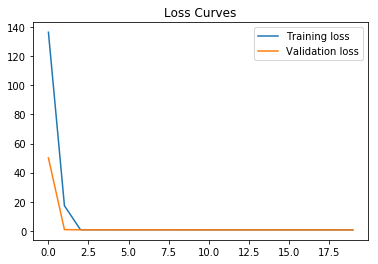

In [35]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             input_dim=wineFeaturesSimple.shape[1],
                             activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Fit
model.fit(wineFeaturesSimple,
          wineLabels,
          epochs=20,
          batch_size=100,
          validation_split=0.2,
          verbose=0)
# Plot results
showRegressionResults(trainHistory)

## Solution

Run the following cell to use a `relu` activation in your first hidden layer. Your loss stays about the same, perhaps declining negligibly to 0.58.

In [ ]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             input_dim=wineFeaturesSimple.shape[1],
                             activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Fit
model.fit(wineFeaturesSimple,
          wineLabels,
          epochs=20,
          batch_size=100,
          validation_split=0.2,
          verbose=0)
# Plot results
showRegressionResults(trainHistory)

# Optimize Your Model

We have two features with one hidden layer but didn't see an improvement. At this point, it's tempting to use all your features with a high-capacity network. However, you must resist the temptation. Instead, follow the guidance in [Model Optimization](https://developers.google.com/machine-learning/testing-debugging/common/optimization) to improve model performance. For a hint and for a discussion, see the following text sections.

Final training loss: 0.6917073906488732
Final Validation loss: 0.6431412926087012


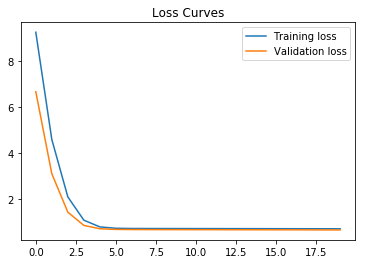

In [38]:
# Choose features
wineFeaturesSimple = wineFeatures[['alcohol', 'volatile acidity']] # add features
# Define
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             activation='relu',
                             input_dim=wineFeaturesSimple.shape[1]))
# Add more layers here
model.add(keras.layers.Dense(1,activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Train
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=20,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)

## Hint

You can try to reduce loss by adding features, adding layers, or playing with the hyperparameters. Before adding more features, check the correlation matrix. Don't expect your loss to decrease by much. Sadly, that is a common experience in machine learning!

## Solution

Run the following code to:

* Add the features chlorides and density.
* Set training epochs to 100.
* Set batch size to 100.

Your loss reduces to about 0.56. That's a minor improvement over the previous loss of 0.58. It seems that adding more features or capacity isn't improving your model by much. Perhaps your model has a bug? In the next section, you will run a sanity check on your model.

Final training loss: 0.5732354443073732
Final Validation loss: 0.5321491246040051


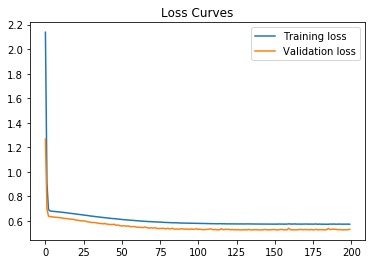

In [39]:
# Choose features
wineFeaturesSimple = wineFeatures[['alcohol','volatile acidity','chlorides','density']]
# Define
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             activation='relu',
                             input_dim=wineFeaturesSimple.shape[1]))
# Add more layers here
model.add(keras.layers.Dense(1,activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Train
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=200,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)

# Check for Implementation Bugs using Reduced Dataset

Your loss isn't decreasing by much. Perhaps your model has an implementation bug. From the [Model Debugging](https://developers.google.com/machine-learning/testing-debugging/common/model-errors) guidelines, a quick test for implementation bugs is to obtain a low loss on a reduced dataset of, say, 10 examples. Remember, passing this test does not validate your modeling approach but only checks for basic implementation bugs. In your ML problem, if your model passes this test, then continue debugging your model to train on your full dataset.

In the following code, experiment with the learning rate, batch size, and number of epochs. Can you reach a low loss? Choose hyperparameter values that let you iterate quickly.

Final training loss: 1.8872096538543701


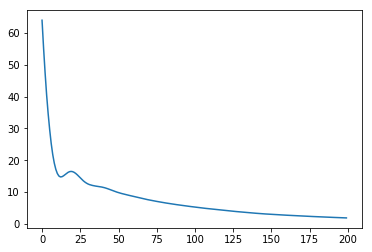

In [41]:
# Choose 10 examples
wineFeaturesSmall = wineFeatures[0:10]
wineLabelsSmall = wineLabels[0:10]
# Define model
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSmall.shape[1],
                             activation='relu',
                             input_dim=wineFeaturesSmall.shape[1]))
model.add(keras.layers.Dense(wineFeaturesSmall.shape[1], activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse') # set LR
# Train
trainHistory = model.fit(wineFeaturesSmall,
                        wineLabelsSmall,
                        epochs=200,
                        batch_size=10,
                        verbose=0)
# Plot results
print("Final training loss: " + str(trainHistory.history['loss'][-1]))
plt.plot(trainHistory.history['loss'])

## Solution

Run the following code cell to train the model using these hyperparameter values:

* learning rate = 0.01
* epochs = 200
* batch size = 10

You get a low loss on your reduced dataset. This result means your model is probably solid and your previous results are as good as they'll get.

In [ ]:
# Choose 10 examples
wineFeaturesSmall = wineFeatures[0:10]
wineLabelsSmall = wineLabels[0:10]
# Define model
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSmall.shape[1], activation='relu',
                             input_dim=wineFeaturesSmall.shape[1]))
model.add(keras.layers.Dense(wineFeaturesSmall.shape[1], activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(0.01), loss='mse') # set LR
# Train
trainHistory = model.fit(wineFeaturesSmall,
                        wineLabelsSmall,
                        epochs=200,
                        batch_size=10,
                        verbose=0)
# Plot results
print("Final training loss: " + str(trainHistory.history['loss'][-1]))
plt.plot(trainHistory.history['loss'])

# Trying a Very Complex Model

Let's go all in and use a very complex model with all the features. For science! And to satisfy ourselves that a simple model is indeed better. Let's use all 11 features with 3 fully-connected relu layers and a final linear layer. The next cell takes a while to run. Skip to the results in the cell after if you like.

Train on 5197 samples, validate on 1300 samples
Epoch 1/100
5197/5197 [==============================] - 0s 82us/sample - loss: 47.1116 - val_loss: 10.0686
Epoch 2/100
5197/5197 [==============================] - 0s 22us/sample - loss: 8.8171 - val_loss: 7.8176
Epoch 3/100
5197/5197 [==============================] - 0s 21us/sample - loss: 6.0159 - val_loss: 3.5455
Epoch 4/100
5197/5197 [==============================] - 0s 21us/sample - loss: 1.9490 - val_loss: 1.3549
Epoch 5/100
5197/5197 [==============================] - 0s 21us/sample - loss: 1.0956 - val_loss: 1.0071
Epoch 6/100
5197/5197 [==============================] - 0s 20us/sample - loss: 0.9080 - val_loss: 0.9113
Epoch 7/100
5197/5197 [==============================] - 0s 19us/sample - loss: 0.8654 - val_loss: 0.8839
Epoch 8/100
5197/5197 [==============================] - 0s 21us/sample - loss: 0.8446 - val_loss: 0.8580
Epoch 9/100
5197/5197 [==============================] - 0s 23us/sample - loss: 0.8224 - val_loss: 0.8

(0.4, 1)

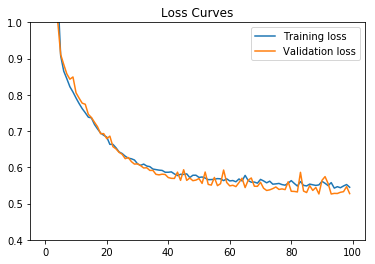

In [42]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeatures.shape[1], activation='relu',
                             input_dim=wineFeatures.shape[1]))
model.add(keras.layers.Dense(wineFeatures.shape[1], activation='relu'))
model.add(keras.layers.Dense(wineFeatures.shape[1], activation='relu'))
model.add(keras.layers.Dense(1,activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Train the model!
trainHistory = model.fit(wineFeatures, wineLabels, epochs=100, batch_size=100,
                         verbose=1, validation_split = 0.2)
# Plot results
showRegressionResults(trainHistory)
plt.ylim(0.4,1)

## Results

If you train for long enough, the minimum achievable MSE is around 0.52, which is a decrease of 0.04 from the previous best loss of 0.56. This decrease probably isn't worth the performance and complexity cost of using all your features and a deeper network. However, that decision depends on the objectives you're optimizing for.

If you train the model long enough, the validation loss actually starts increasing while training loss continues to decrease. This divergence in loss curves means your model is overfitting. The overfitting results from the closer fit that your very complex model can learn. Stick with the simpler model. You'll be happier and live longer!

If you do want to optimize your loss, then play with the model to find the minimum achievable training loss before overfitting sets in. Try playing with the network parameters in the code cell above to achieve a loss of 0.51. But be warned—optimizing your loss could take a lot of trial and error..

# Conclusion

This Colab demonstrated the following principles:

* The most important step in machine learning is understanding your data.
* The largest gains come from the initial features and network.
* Returns diminish as you add features and complexity.
* Incremental development provides confidence in model quality and allows benchmarking against previous results.
* Reproducing previous results is extremely important. Hence, always use version control.